## load module

In [1]:
import random
import json
import csv
import os
from collections import Counter
import warnings

import numpy as np
import pandas as pd
import umap
import hdbscan
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import torch
from torch import nn
from datasets import Dataset
from transformers import BertTokenizer,BertModel
from transformers import AutoConfig, AutoModel, AutoTokenizer
from tokenizers.normalizers import BertNormalizer

from nltk import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Loading NLTK dataset
import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('punkt')

print(os.getcwd())

NOTE: Redirects are currently not supported in Windows or MacOs.


C:\Users\shaohan.tian\OneDrive\code\code_github\SteelBERTa\model_evaluation\action_cluster


## Data loading and cleaning

In [2]:
normalize = BertNormalizer(
    lowercase=False,
    strip_accents=True,
    clean_text=True,
    handle_chinese_chars=True
)

def normalize_text(text):
    """
    Normalize abstracts.
    """
    return normalize.normalize_str(text)

In [3]:
with open(r"./tokens_n.json", 'r', encoding='utf-8') as f:
    toks = json.load(f)
    
with open(r"./chunks_n.json", 'r', encoding='utf-8') as c:
    chunks = json.load(c)

In [4]:
# chunks = []
df = pd.DataFrame(toks+chunks, columns=['text'])
df['text'] = df['text'].apply(normalize_text)
print(df.shape)
df.head()

(898, 1)


,text
0,tempered
1,soaking
2,reheated
3,quenched
4,normalized


In [5]:
tokens_dataset = Dataset.from_pandas(df)
tokens_dataset

Dataset({
    features: ['text'],
    num_rows: 898
})

## Embeddings

In [53]:
bert_df = df.copy()
bert_df.head()

,Topic,Doc
0,-1,growth tests;microhardness tests;x-ray diffrac...
1,0,reheated ;austenitized;solution-treated;lst-tr...
2,1,cyclic voltammetry -lrb- cv -rrb-;x-ray diffra...
3,2,charpy v - notch impact tests;tem observations...
4,3,ion-milled;ion milling process;neutron irradia...


In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device='cpu'

# model_name = 'bert-base-uncased'
# model_name = 'microsoft/deberta-v3-base'
# model_name = 'm3rg-iitd/matscibert'
model_name = './../../model_saved/checkpoint-140000'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)

def cls_pooling(model_output):
    return model_output.last_hidden_state[:, 0]

def get_embeddings(text_list):
    encoded_input = tokenizer(
        text_list, padding='max_length', max_length = 512, truncation=True, return_tensors="pt"
    )
    encoded_input = {k: v.to(device) for k, v in encoded_input.items()}
    model_output = model(**encoded_input)
    return cls_pooling(model_output)

# def get_embedding(text):
#     encoded_input = tokenizer(text, padding='max_length', max_length = 512,
#                               truncation=True,  return_tensors="pt").to(device)
#     model_output = model(**encoded_input)
#     # if 'pooler_output' in model_output.keys():
#     #     return model_output['pooler_output']
#     # else:
#     return model_output['last_hidden_state'][:,0]

embedding = get_embeddings(tokens_dataset['text'][0])
embedding.shape

Some weights of the model checkpoint at ./../../model_saved/checkpoint-140000 were not used when initializing DebertaV2Model: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ C:\Users\shaohan.tian\AppData\Local\Temp\ipykernel_18872\1473260368.py:31 in <module>            │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ 'C:\\Users\\shaohan.tian\\AppData\\Local\\Temp\\ipykernel_18872\\1473260368.py'                  │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'tokens_dataset' is not defined

In [ ]:
embeddings_dataset = tokens_dataset.map(
    lambda x: {"embeddings": get_embeddings(x["text"]).detach().cpu().numpy()[0]}
)
embeddings_dataset

In [9]:
temp_bert_df = pd.DataFrame(embeddings_dataset['embeddings'], columns=[str(i) for i in range(768)])
# temp_bert_df.reset_index(inplace=True, drop=True)
new_df = pd.concat([bert_df, temp_bert_df], axis=1)
print(new_df.shape)
new_df.head()

(898, 769)


,text,0,1,2,3,4,5,6,7,8,...,758,759,760,761,762,763,764,765,766,767
0,tempered,0.463398,-0.332064,0.216027,-0.302143,0.749939,-1.499172,-0.108854,-0.745578,0.411344,...,0.180599,-0.087170,0.681342,-0.334720,-0.346851,1.127310,0.158163,0.139975,0.071658,0.913339
1,soaking,0.308205,-0.215305,0.861973,-0.425972,0.288957,-1.148215,0.372393,-0.531333,0.968894,...,-0.176768,0.899885,-0.331092,-0.349473,-0.042653,0.596424,0.271853,-0.463320,-0.661551,0.155960
2,reheated,-0.062744,0.241940,0.882535,-0.068771,0.705864,-1.239786,0.529970,-0.229032,-0.131724,...,0.162493,0.518710,-0.436103,-0.046141,1.126805,1.047850,-0.475595,-0.618747,0.036080,0.081884
3,quenched,0.717653,0.104691,0.481501,-0.275932,0.965484,-1.413366,0.708816,-0.410669,-0.224809,...,0.595125,0.428158,-0.274093,-0.504535,-0.314873,1.525232,0.455215,0.122821,0.415558,0.706243
4,normalized,0.577197,0.953073,0.034296,0.605652,1.063637,-0.814207,0.170559,-1.871806,-0.248571,...,-0.595914,0.664564,0.503267,-0.197049,0.410833,1.371796,0.032309,-0.304321,0.387437,0.340692


In [10]:
new_df.to_csv('tokens_embeddings.csv', encoding='utf-8', index=None)

## Clustering

In [20]:
dataset = pd.read_csv('tokens_embeddings.csv', encoding='utf-8')
print(dataset.shape)
dataset.head()

(898, 769)


,text,0,1,2,3,4,5,6,7,8,...,758,759,760,761,762,763,764,765,766,767
0,tempered,0.463398,-0.332064,0.216027,-0.302143,0.749939,-1.499172,-0.108854,-0.745578,0.411344,...,0.180599,-0.087170,0.681342,-0.334720,-0.346851,1.127310,0.158163,0.139975,0.071658,0.913339
1,soaking,0.308205,-0.215305,0.861973,-0.425972,0.288957,-1.148215,0.372393,-0.531333,0.968894,...,-0.176768,0.899885,-0.331092,-0.349473,-0.042653,0.596424,0.271853,-0.463320,-0.661551,0.155960
2,reheated,-0.062744,0.241940,0.882535,-0.068771,0.705864,-1.239786,0.529970,-0.229032,-0.131724,...,0.162493,0.518710,-0.436103,-0.046141,1.126805,1.047850,-0.475595,-0.618747,0.036080,0.081884
3,quenched,0.717653,0.104691,0.481501,-0.275932,0.965484,-1.413366,0.708816,-0.410669,-0.224809,...,0.595125,0.428158,-0.274093,-0.504535,-0.314873,1.525232,0.455215,0.122821,0.415558,0.706243
4,normalized,0.577197,0.953073,0.034296,0.605652,1.063637,-0.814207,0.170559,-1.871806,-0.248571,...,-0.595914,0.664564,0.503267,-0.197049,0.410833,1.371796,0.032309,-0.304321,0.387437,0.340692


In [12]:
# data2 = data.dropna(subset=['0'])
# df=df.dropna().reset_index(drop=True)

In [21]:
df = dataset.dropna().reset_index(drop=True).iloc[:, :]
embeddings = df.iloc[:, 1:].to_numpy()
embeddings.shape

(898, 768)

In [22]:
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score

def cluster_quan(x, labels):
    """
    Cluster evaluation.
    """
    dbi = davies_bouldin_score(x, labels)
    si = silhouette_score(x, labels)
    chs = calinski_harabasz_score(x, labels)

    return dbi, si, chs

In [50]:
def cluster_umap_hdbscan(data, n_neighbors=5, n_components=3, min_cluster_size=5,
                         min_dist=0.1, fig_name='./topic_model.png'):
    
    # reduce dimensionality 
    umap_embeddings = umap.UMAP(n_neighbors=n_neighbors, 
                                n_components=n_components,
                                min_dist=min_dist,                            
                                random_state=seed,
                                metric='cosine').fit_transform(data)

    # cluster
    clusters = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                            metric='euclidean',                      
                            cluster_selection_method='eom').fit(umap_embeddings)

    # Prepare data
    umap_data = umap.UMAP(n_neighbors=n_neighbors, 
                            n_components=2,
                            min_dist=min_dist,                            
                            random_state=seed,
                            metric='cosine').fit_transform(data)
    
    result = pd.DataFrame(umap_data, columns=['x', 'y'])
    result['labels'] = clusters.labels_

    # Visualize clusters
    fig, ax = plt.subplots(figsize=(10, 5), dpi=1000)
    # plt.xlim([-10, 13])
    # plt.ylim([-12, 15])

    outliers = result.loc[result.labels == -1, :]
    clustered = result.loc[result.labels != -1, :]
    plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=10)
    plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=10, cmap='hsv_r')
    plt.title(fig_name[12:-3])
    plt.colorbar()
    plt.savefig(fig_name)
    
    dbi, si, chs = cluster_quan(clustered, clustered.labels)
    print(dbi, si, chs)
    
    result.to_excel('actions.xlsx')
    print(f"there are {len(set(clusters.labels_))} clusters")
    
    return dbi, si, chs

In [16]:
cluster_umap_hdbscan(data, n_neighbors=1200, n_components=2, min_cluster_size=30,
                         min_dist=0.1, fig_name='./topic_model.png')

In [6]:
# import csv
# seed = 666

# field_names = ['n_neighbors', 'n_components', 'min_cluster_size', 'min_dist', 'dbi', 'si', 'chs']
# with open(r'./topic_cluster.csv', 'a+') as csvfile:
#     writer = csv.DictWriter(csvfile, fieldnames=field_names)
#     writer.writeheader()

#     for n_neighbors in tqdm(np.arange(10, 60, 5)):
#         for n_components in range(2, 3):
#             for min_cluster_size in range(20, 40, 5):
#                 for min_dist in np.arange(0.1, 0.95, 0.05):
                    
#                     name = f"./topic_img/Nei-{n_neighbors}_Comp-{n_components}_MLS-{min_cluster_size}_MD-{min_dist}.png"
#                     dbi, si, chs = cluster_umap_hdbscan(embeddings, n_neighbors=n_neighbors, n_components=n_components,
#                                                         min_cluster_size=min_cluster_size, min_dist=min_dist, fig_name=name)
                    
#                     result = {'n_neighbors':n_neighbors, 'n_components':n_components, 'min_cluster_size':min_cluster_size,
#                               'min_dist':min_dist, 'dbi':dbi, 'si':si, 'chs':chs}
#                     writer.writerows([result])
#                     # print(p, cluster_quan(dr_tsne(embeddings, n_components=2, perplexity=p, seed=888), pt_with_labels['labels']))

0.4090792453472262 0.5712913327844318 953.6975030896552
there are 10 clusters


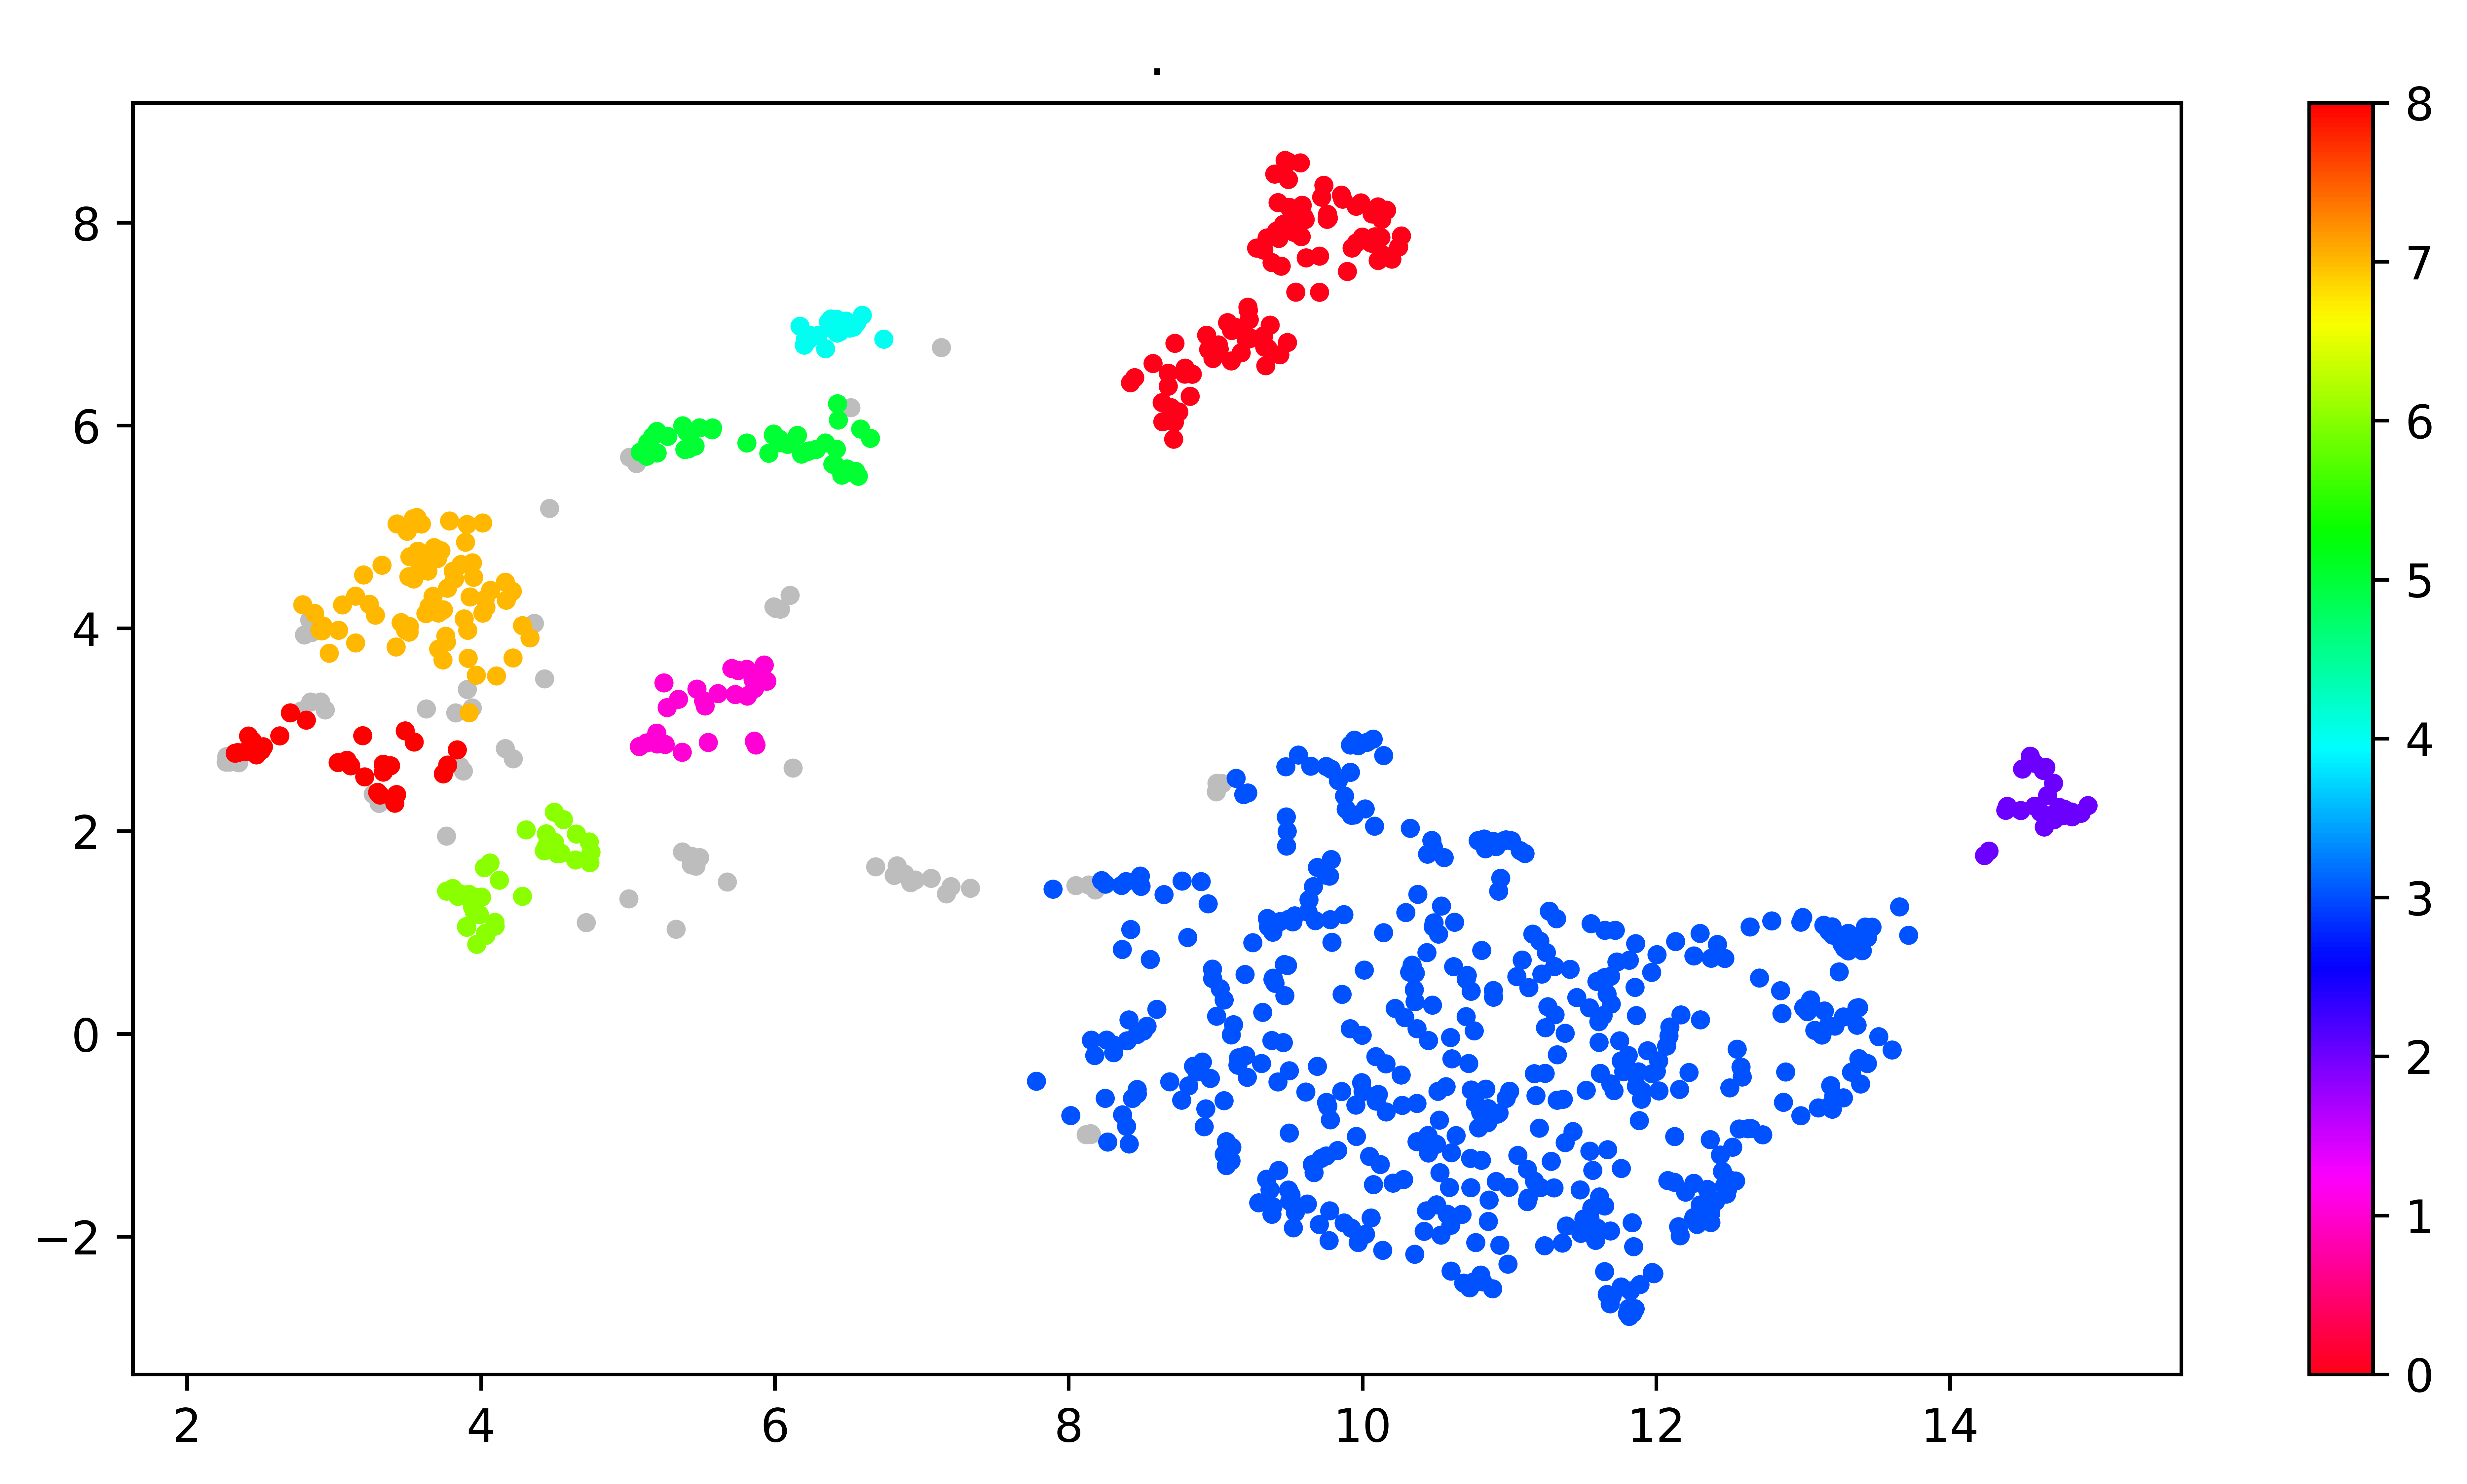

In [51]:
import csv

seed = 42
n_neighbors = 15
n_components = 2
min_cluster_size = 15
min_dist = 0.2

name = f"final_output.png"
dbi, si, chs = cluster_umap_hdbscan(embeddings, n_neighbors=n_neighbors, n_components=n_components,
                                min_cluster_size=min_cluster_size, min_dist=min_dist, fig_name=name)

result = {'n_neighbors':n_neighbors, 'n_components':n_components, 'min_cluster_size':min_cluster_size,
      'min_dist':min_dist, 'dbi':dbi, 'si':si, 'chs':chs}

### plot

there are 12 clusters and 25 noise points.


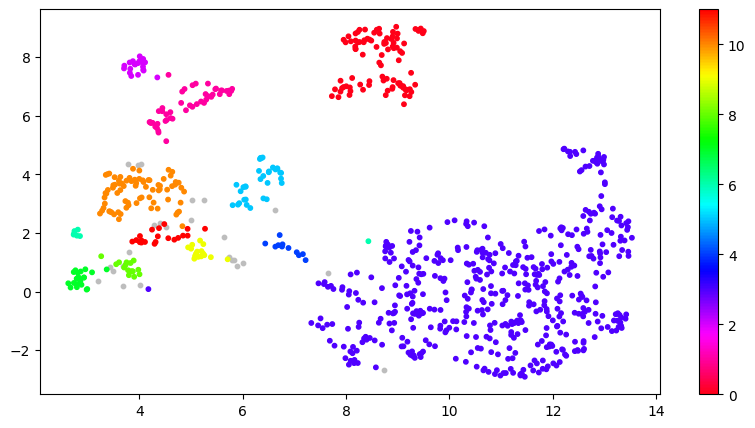

In [6]:
########## final result
n_neighbors = 12
n_components = 3
min_cluster_size = 6
min_dist = 0.27
seed = 666
fig_name = './topic_model.png'

# reduce dimensionality 
umap_embeddings = umap.UMAP(n_neighbors=n_neighbors, 
                            n_components=n_components,
                            min_dist=min_dist,                            
                            random_state=seed,
                            metric='cosine').fit_transform(embeddings)

# cluster
cluster = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

# Prepare data
umap_data = umap.UMAP(n_neighbors=n_neighbors, 
                            n_components=2,
                            min_dist=min_dist,                            
                            random_state=seed,
                            metric='cosine').fit_transform(embeddings)

result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
# plt.xlim([-10, 13])
# plt.ylim([-12, 15])

outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=10)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=10, cmap='hsv_r')
plt.colorbar()
# plt.savefig('actions_cluster.png')

# couter cluster labels
from collections import Counter

n = len(Counter(clustered['labels']))
print(f'there are {n} clusters and {Counter(cluster.labels_)[-1]} noise points.')

## Cleaning

In [20]:
# def text_proc(text):
#     """text cleaning"""
    
#     # Convert plural verb into sungular verb
#     lemmatizer = WordNetLemmatizer()
#     print("Length of stopwords: ", len(stop_words))
#     print("\nLemmatization")
#     print("rocks :", lemmatizer.lemmatize("rocks")) 

# # Removing duplicate values
# def duplicate_content_removal(data, col, ini_row):
#     print("\nBefore removing duplicates, number of data was : ", ini_row)
#     duplicate_count = data[col].duplicated().sum()
#     print("\nNumber of Duplicates: ", duplicate_count)

#     description_data = data[col].drop_duplicates()
#     cleaned_row = len(description_data)
    
#     if (ini_row - cleaned_row) > 0:
#         print("\nTotal data reduction : ", (ini_row - cleaned_row))
#         print("\nAfter removing duplicates, number of data is :", cleaned_row)
#     else:
#         print("\nDataset doesn't content any duplicate data.")
    
#     return list(description_data)

## Postprecessing

In [55]:
df_label = pd.read_excel('./formal_result.xlsx')
df_label.head()

,Topic,Doc
0,-1,growth tests;microhardness tests;x-ray diffrac...
1,0,reheated ;austenitized;solution-treated;lst-tr...
2,1,cyclic voltammetry -lrb- cv -rrb-;x-ray diffra...
3,2,charpy v - notch impact tests;tem observations...
4,3,ion-milled;ion milling process;neutron irradia...


In [56]:
df = pd.read_excel('./actions.xlsx')
df.head()

,text,x,y,labels
0,tempered,10.271434,-0.705825,3
1,soaking,9.781964,-0.848490,3
2,reheated,9.762704,8.082760,0
3,quenched,10.930212,-0.780091,3
4,normalized,10.919875,-0.791545,3


In [69]:
text = 'tempered'
new_label = []
for t in df['text']:
    for i in range(len(df_label)):
        if t in df_label.iloc[i, 1].split(';'):
            new_label.append(i)

In [70]:
len(new_label)

898

In [71]:
df['new_label'] = new_label
df.head()

,text,x,y,labels,new_label
0,tempered,10.271434,-0.705825,3,8
1,soaking,9.781964,-0.848490,3,8
2,reheated,9.762704,8.082760,0,1
3,quenched,10.930212,-0.780091,3,8
4,normalized,10.919875,-0.791545,3,8


In [72]:
df.to_excel('final_output.xlsx')

## shape

In [28]:
df = pd.read_excel('final_output.xlsx')
df.head()

,text,x,y,new_label
0,cyclic voltammetry -lrb- cv -rrb-,6.509074,6.960414,2
1,x-ray diffraction -lrb- xrd -rrb-,6.365563,7.020462,2
2,post-weld heat treatment -lrb- pwht -rrb-,7.133437,6.768313,2
3,electrochemical impedance spectroscopy -lrb- e...,6.383280,7.049937,2
4,scanning electron microscopy -lrb- sem -rrb-,6.442889,6.923699,2


In [29]:
from scipy.spatial import distance

center_x = []
center_y = []
dist = []
for i in tqdm(range(len(df))):
    mini_df = df[df['new_label']==df.iloc[i, -1]]
    center_x.append(mini_df['x'].mean())
    center_y.append(mini_df['y'].mean())
    d = distance.euclidean((mini_df['x'].mean(), mini_df['y'].mean()), (df.iloc[i, 1], df.iloc[i, 2]))
    dist.append(d*40.0)

100%|█████████████████████████████████████████████████| 751/751 [00:00<00:00, 761.38it/s]


In [30]:
df['center_x'] = center_x
df['center_y'] = center_y
df['dist'] = dist
df.head()

,text,x,y,new_label,center_x,center_y,dist
0,cyclic voltammetry -lrb- cv -rrb-,6.509074,6.960414,2,6.4279,6.927954,3.496932
1,x-ray diffraction -lrb- xrd -rrb-,6.365563,7.020462,2,6.4279,6.927954,4.462024
2,post-weld heat treatment -lrb- pwht -rrb-,7.133437,6.768313,2,6.4279,6.927954,28.934909
3,electrochemical impedance spectroscopy -lrb- e...,6.383280,7.049937,2,6.4279,6.927954,5.195513
4,scanning electron microscopy -lrb- sem -rrb-,6.442889,6.923699,2,6.4279,6.927954,0.623258


In [31]:
df.to_excel('out.xlsx')